In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from pytorch_msssim import ms_ssim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [1]:
import numpy as np
import torch.nn.functional as F
import torch

# === 1. 加载原始 HR 数据 ===
hr_train = np.load("tm/HR_data_train_tm.npy")[:1500]
hr_valid = np.load("tm/HR_data_valid_tm.npy")[:1500]
hr_test = np.load("tm/HR_data_test_tm.npy")[:1500]

# === 2. 生成 LR 数据（双线性插值至 16×16） ===
def downsample(hr_array, scale=4):
    tensor = torch.tensor(hr_array, dtype=torch.float32)
    return F.interpolate(tensor, scale_factor=1/scale, mode="bilinear", align_corners=False).numpy()

lr_train = downsample(hr_train)
lr_valid = downsample(hr_valid)
lr_test = downsample(hr_test)

# === 3. 保存为 .npy 文件 ===
np.save("tm/HR_data_train_40.npy", hr_train)
np.save("tm/LR_data_train_40.npy", lr_train)
np.save("tm/HR_data_valid_40.npy", hr_valid)
np.save("tm/LR_data_valid_40.npy", lr_valid)
np.save("tm/HR_data_test_40.npy", hr_test)
np.save("tm/LR_data_test_40.npy", lr_test)

# === 4. mean和std===
mean = np.mean(hr_train, axis=(0, 2, 3))[:, None, None]
std = np.std(hr_train, axis=(0, 2, 3))[:, None, None]
np.save("tm/mean_40.npy", mean)
np.save("tm/std_40.npy", std)

# 每个通道的 min 和 max（例如 2 个通道）
hr_min = hr_train.min(axis=(0, 2, 3))  # shape: (2,)
hr_max = hr_train.max(axis=(0, 2, 3))

# 保存为 .npy 文件，后续评估使用
np.save("tm/min_40.npy", hr_min.astype(np.float32))
np.save("tm/max_40.npy", hr_max.astype(np.float32))

print("✅ 完成：生成 LR/HR 切片、保存归一化参数，包括 test")


✅ 完成：生成 LR/HR 切片、保存归一化参数，包括 test


In [13]:
class WeatherDataset(Dataset):
    def __init__(self, lr_path, hr_path, mean_path, std_path):
        self.lr = np.load(lr_path)
        self.hr = np.load(hr_path)
        self.mean = np.load(mean_path).reshape(2, 1, 1)
        self.std = np.load(std_path).reshape(2, 1, 1)

    def __len__(self):
        return len(self.lr)

    def __getitem__(self, idx):
        lr = (self.lr[idx] - self.mean) / self.std
        hr = (self.hr[idx] - self.mean) / self.std
        return torch.tensor(lr, dtype=torch.float32), torch.tensor(hr, dtype=torch.float32)


In [14]:
from torchvision.models import resnet18

class PretrainedGeneratorUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, features=64):
        super().__init__()
        
        # 获取预训练的 resnet18 模型
        resnet = resnet18(pretrained=True)
        
        # 适配输入通道为 2（默认是 RGB 3 通道）
        self.input_adapter = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # 拿出前几层作为 encoder
        self.encoder = nn.Sequential(
            self.input_adapter,  # 替代原始 conv1
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,  # 输出 64x64 → 32x32
            resnet.layer2,  # 32x32 → 16x16
            resnet.layer3   # 16x16 → 8x8
        )
        
        # 后面的 decoder 保持类似
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, features * 2, 4, 2, 1),  # 8×8 → 16×16
            nn.BatchNorm2d(features * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(features * 2, features, 4, 2, 1),  # 16×16 → 32×32
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.ConvTranspose2d(features, features, 4, 2, 1),  # 32×32 → 64×64
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.ConvTranspose2d(features, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


/opt/anaconda3/envs/esrgan-env/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/esrgan-env/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <4C793A59-B32A-3AF1-BEA5-03AD7C5C80C6> /opt/anaconda3/envs/esrgan-env/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/esrgan-env/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/esrgan-env/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/esrgan-env/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/esrgan-env/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. D

In [15]:
class RelativisticDiscriminator(nn.Module):
    def __init__(self, in_channels=4, features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features * 2, 4, 2, 1),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 2, features * 4, 4, 2, 1),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 4, 1, 4, 1, 1)
        )

    def forward(self, lr_up, hr_or_fake):
        x = torch.cat([lr_up, hr_or_fake], dim=1)  # => [B, 4, H, W]
        return self.model(x)  # 不加 Sigmoid，用 BCEWithLogitsLoss


In [16]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.nn.functional as F

def compute_psnr_ssim(pred, target):
    # 转换为 numpy 格式，shape: (N, H, W, C)
    pred = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
    target = target.detach().cpu().numpy().transpose(0, 2, 3, 1)
    data_range = max(target.max(), pred.max()) - min(target.min(), pred.min())
    psnr_total, ssim_total = 0, 0
    for p, t in zip(pred, target):
        psnr_total += peak_signal_noise_ratio(t, p, data_range=data_range)
        ssim_total += structural_similarity(t, p, channel_axis=-1, data_range=data_range)
    
    return psnr_total / len(pred), ssim_total / len(pred)

def compute_rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

def compute_mae(pred, target):
    return torch.mean(torch.abs(pred - target))

# === 添加 SSIM Loss ===
def ssim_loss(pred, target, C1=0.01**2, C2=0.03**2):
    mu_x = F.avg_pool2d(pred, 3, 1, 1)
    mu_y = F.avg_pool2d(target, 3, 1, 1)
    sigma_x = F.avg_pool2d(pred ** 2, 3, 1, 1) - mu_x ** 2
    sigma_y = F.avg_pool2d(target ** 2, 3, 1, 1) - mu_y ** 2
    sigma_xy = F.avg_pool2d(pred * target, 3, 1, 1) - mu_x * mu_y
    ssim_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    ssim_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    ssim_map = ssim_n / (ssim_d + 1e-8)
    return 1 - ssim_map.mean()

# 加载 min/max（你刚才保存过）
hr_min = np.load("tm/min_40.npy")[:, None, None]
hr_max = np.load("tm/max_40.npy")[:, None, None]

def minmax_scale(tensor):
    # 缩放到 0~1
    return (tensor - torch.tensor(hr_min, dtype=torch.float32).to(tensor.device)) / \
           (torch.tensor(hr_max - hr_min, dtype=torch.float32).to(tensor.device))



In [17]:
train_set = WeatherDataset(
    "tm/LR_data_train_40.npy", "tm/HR_data_train_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)
val_set = WeatherDataset(
    "tm/LR_data_valid_40.npy", "tm/HR_data_valid_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)
test_set = WeatherDataset(
    "tm/LR_data_test_40.npy", "tm/HR_data_test_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)

test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


In [22]:
# === 6. Model Initialization ===
G = PretrainedGeneratorUNet().to(device)
# 可选：冻结 encoder 参数
for param in G.encoder.parameters():
    param.requires_grad = False

D = RelativisticDiscriminator().to(device)
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
opt_G = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), 
                         lr=1e-4, betas=(0.5, 0.999), weight_decay=1e-4)

opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999), weight_decay=1e-4)
G.eval()
with torch.no_grad():
    dummy_input = torch.randn(1, 2, 16, 16).to(device)
    dummy_output = G(dummy_input)
    print(f"✅ G output shape: {dummy_output.shape}")



✅ G output shape: torch.Size([1, 2, 16, 16])


In [25]:
# === Step 1: Pretrain Generator only ===
pretrain_epochs = 30
print("🔧 预训练阶段开始")
for epoch in range(pretrain_epochs):
    G.train()
    total_loss = 0
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        fake = G(lr)
        # 保证 fake 和 hr 是同样大小
        if fake.shape[-2:] != hr.shape[-2:]:
            fake = F.interpolate(fake, size=hr.shape[-2:], mode="bilinear", align_corners=False)
        loss = criterion_L1(fake, hr) + ssim_loss(fake, hr)
        opt_G.zero_grad()
        loss.backward()
        opt_G.step()
        total_loss += loss.item()
    print(f"[Pretrain Epoch {epoch+1}/{pretrain_epochs}] G-Loss = {total_loss:.4f}")


🔧 预训练阶段开始
[Pretrain Epoch 1/30] G-Loss = 63.2277
[Pretrain Epoch 2/30] G-Loss = 47.8322
[Pretrain Epoch 3/30] G-Loss = 44.1537
[Pretrain Epoch 4/30] G-Loss = 42.1529
[Pretrain Epoch 5/30] G-Loss = 41.4830
[Pretrain Epoch 6/30] G-Loss = 40.8113
[Pretrain Epoch 7/30] G-Loss = 40.4242
[Pretrain Epoch 8/30] G-Loss = 40.0670
[Pretrain Epoch 9/30] G-Loss = 39.6719
[Pretrain Epoch 10/30] G-Loss = 39.6763
[Pretrain Epoch 11/30] G-Loss = 39.2391
[Pretrain Epoch 12/30] G-Loss = 39.1352
[Pretrain Epoch 13/30] G-Loss = 38.8859
[Pretrain Epoch 14/30] G-Loss = 38.8693
[Pretrain Epoch 15/30] G-Loss = 38.3892
[Pretrain Epoch 16/30] G-Loss = 38.4238
[Pretrain Epoch 17/30] G-Loss = 38.2732
[Pretrain Epoch 18/30] G-Loss = 38.0924
[Pretrain Epoch 19/30] G-Loss = 38.0842
[Pretrain Epoch 20/30] G-Loss = 37.7945
[Pretrain Epoch 21/30] G-Loss = 37.5539
[Pretrain Epoch 22/30] G-Loss = 37.3827
[Pretrain Epoch 23/30] G-Loss = 37.3652
[Pretrain Epoch 24/30] G-Loss = 37.0942
[Pretrain Epoch 25/30] G-Loss = 37.0260

In [26]:
num_epochs = 200
train_psnrs, train_ssims, train_rmses, train_maes = [], [], [], []
val_psnrs, val_ssims, val_rmses, val_maes = [], [], [], []


for epoch in range(num_epochs):
    G.train()
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)

        # === Forward Generator ===
        fake = G(lr)

        # 强制生成图像和真实图像同尺寸
        fake = F.interpolate(fake, size=hr.shape[-2:], mode="bilinear", align_corners=False)

        # 再上采样 LR 用于判别器
        lr_up = F.interpolate(lr, size=hr.shape[-2:], mode="bilinear", align_corners=False)

        # 判别器拼接时不会报错
        D_fake = D(lr_up, fake.detach())
        D_real = D(lr_up, hr)


        loss_D_real = criterion_GAN(D_real - D_fake.mean(), torch.ones_like(D_real))
        loss_D_fake = criterion_GAN(D_fake - D_real.mean(), torch.zeros_like(D_fake))
        loss_D = (loss_D_real + loss_D_fake) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()


        # === Train Generator ===
        pred_real = D(lr_up, hr).detach()
        pred_fake = D(lr_up, fake)

        loss_gan = criterion_GAN(pred_fake - pred_real.mean(), torch.ones_like(pred_fake))
        loss_ssim = ssim_loss(fake, hr)
        loss_l1 = criterion_L1(fake, hr)
        loss_G = 0.01 * loss_gan + 1.0 * loss_ssim + 1.0 * loss_l1

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()



    train_pred = G(lr)
    train_pred = F.interpolate(train_pred, size=hr.shape[-2:], mode="bilinear", align_corners=False).to(device)
    # 评估
    train_pred_mm = minmax_scale(train_pred)
    hr_mm = minmax_scale(hr)
    psnr_train, ssim_train = compute_psnr_ssim(train_pred, hr)
    rmse_train = compute_rmse(train_pred_mm, hr_mm)
    mae_train = compute_mae(train_pred_mm, hr_mm)
    # 添加保存
    train_psnrs.append(psnr_train)
    train_ssims.append(ssim_train)
    train_rmses.append(rmse_train)
    train_maes.append(mae_train)

    G.eval()
    with torch.no_grad():
        val_lr, val_hr = next(iter(val_loader))
        val_lr, val_hr = val_lr.to(device), val_hr.to(device)
        pred_hr = G(val_lr)
        pred_hr = F.interpolate(pred_hr, size=val_hr.shape[-2:], mode="bilinear", align_corners=False).to(device)
        # 计算指标
        pred_val_mm = minmax_scale(pred_hr)
        val_hr_mm = minmax_scale(val_hr)
        psnr_val, ssim_val = compute_psnr_ssim(pred_hr, val_hr)
        rmse_val = compute_rmse(pred_val_mm, val_hr_mm)
        mae_val = compute_mae(pred_val_mm, val_hr_mm)
        # 添加保存
        val_psnrs.append(psnr_val)
        val_ssims.append(ssim_val)
        val_rmses.append(rmse_val)
        val_maes.append(mae_val)

    # === Print summary ===
    print(f"Epoch {epoch+1}: "
          f"Train PSNR={psnr_train:.2f}, SSIM={ssim_train:.4f}, RMSE={rmse_train:.4f}, MAE={mae_train:.4f} | "
          f"Valid PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}, RMSE={rmse_val:.4f}, MAE={mae_val:.4f}")

Epoch 1: Train PSNR=25.59, SSIM=0.7118, RMSE=0.0064, MAE=0.0030 | Valid PSNR=22.47, SSIM=0.6555, RMSE=0.0081, MAE=0.0042
Epoch 2: Train PSNR=25.37, SSIM=0.7092, RMSE=0.0067, MAE=0.0030 | Valid PSNR=22.41, SSIM=0.6502, RMSE=0.0082, MAE=0.0043
Epoch 3: Train PSNR=25.17, SSIM=0.6924, RMSE=0.0056, MAE=0.0027 | Valid PSNR=22.56, SSIM=0.6503, RMSE=0.0080, MAE=0.0042
Epoch 4: Train PSNR=24.58, SSIM=0.6754, RMSE=0.0067, MAE=0.0033 | Valid PSNR=22.51, SSIM=0.6567, RMSE=0.0081, MAE=0.0042
Epoch 5: Train PSNR=25.36, SSIM=0.7038, RMSE=0.0051, MAE=0.0024 | Valid PSNR=22.49, SSIM=0.6455, RMSE=0.0081, MAE=0.0042
Epoch 6: Train PSNR=25.17, SSIM=0.6856, RMSE=0.0069, MAE=0.0034 | Valid PSNR=22.53, SSIM=0.6534, RMSE=0.0080, MAE=0.0042
Epoch 7: Train PSNR=25.14, SSIM=0.7122, RMSE=0.0065, MAE=0.0030 | Valid PSNR=22.49, SSIM=0.6578, RMSE=0.0081, MAE=0.0042
Epoch 8: Train PSNR=25.30, SSIM=0.7001, RMSE=0.0055, MAE=0.0026 | Valid PSNR=22.55, SSIM=0.6533, RMSE=0.0080, MAE=0.0042
Epoch 9: Train PSNR=25.42, SSIM=

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# === 1. 加载测试集 ===
test_set = WeatherDataset(
    "tm/LR_data_test_40.npy", "tm/HR_data_test_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# === 2. 在测试集上评估模型 ===
G.eval()
test_psnrs, test_ssims, test_rmses, test_maes = [], [], [], []
images_to_show = []  # 原图、真实图、预测图（反归一化后）

# 反归一化函数
mean = np.load("tm/mean_40.npy")
std = np.load("tm/std_40.npy")
def denormalize(tensor):
    return tensor * torch.tensor(std).to(tensor.device) + torch.tensor(mean).to(tensor.device)

with torch.no_grad():
    for test_lr, test_hr in test_loader:
        test_lr, test_hr = test_lr.to(device), test_hr.to(device)
        pred_test = G(test_lr)
        pred_test = F.interpolate(pred_test, size=test_hr.shape[-2:], mode="bilinear", align_corners=False)

        # 计算指标（归一化下）
        pred_mm = minmax_scale(pred_test)
        hr_mm = minmax_scale(test_hr)
        psnr, ssim = compute_psnr_ssim(pred_test, test_hr)
        rmse = compute_rmse(pred_mm, hr_mm)
        mae = compute_mae(pred_mm, hr_mm)
        test_psnrs.append(psnr)
        test_ssims.append(ssim)
        test_rmses.append(rmse.cpu().item())
        test_maes.append(mae.cpu().item())

        # 可视化：选取前1张图，反归一化
        for i in range(1):
            lr_img = F.interpolate(test_lr[i:i+1], size=(64, 64), mode="bilinear", align_corners=False)
            images_to_show.append((
                denormalize(lr_img[0].cpu()),
                denormalize(test_hr[i].cpu()),
                denormalize(pred_test[i].cpu())
            ))

# === 3. 打印测试集平均指标 ===
print(f"Test Set Evaluation:")
print(f"PSNR: {np.mean(test_psnrs):.2f}")
print(f"SSIM: {np.mean(test_ssims):.4f}")
print(f"RMSE: {np.mean(test_rmses):.4f}")
print(f"MAE: {np.mean(test_maes):.4f}")


Test Set Evaluation:
PSNR: 23.91
SSIM: 0.8428
RMSE: 0.0072
MAE: 0.0035


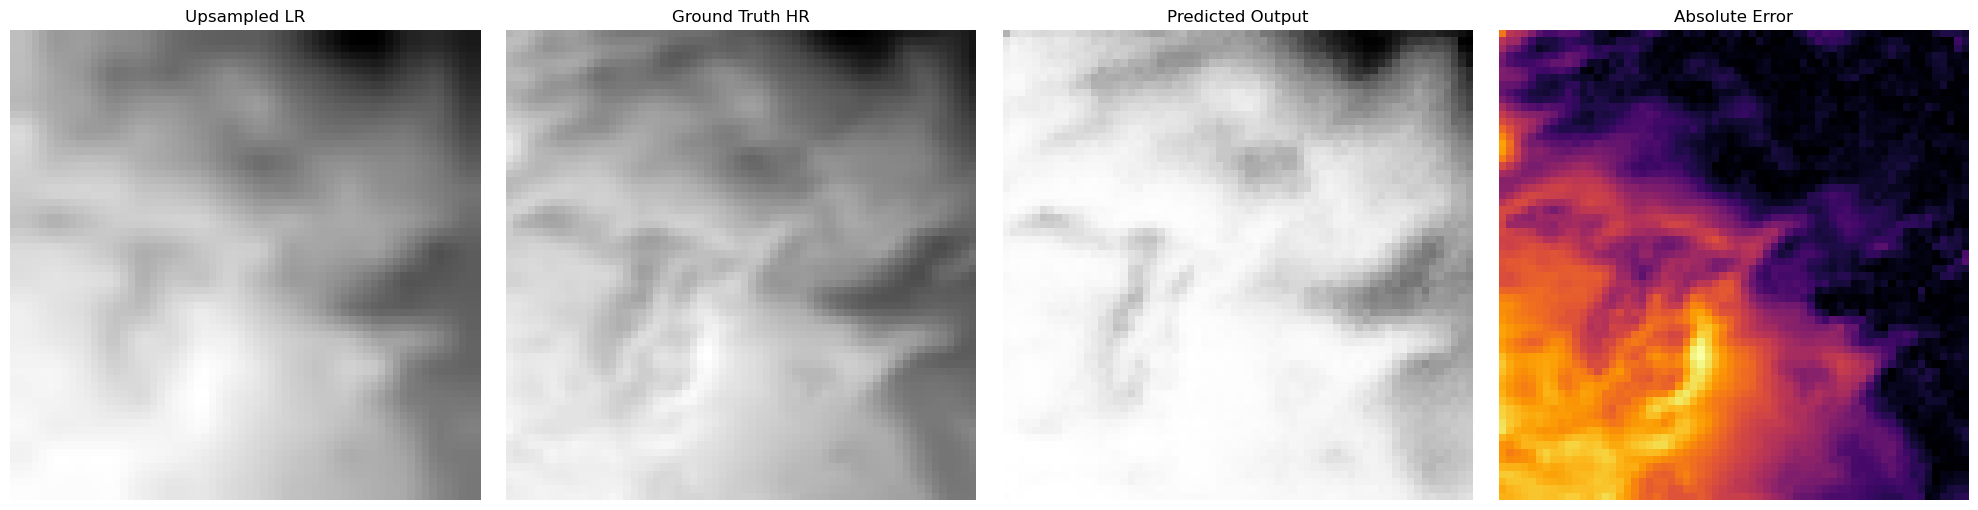

In [10]:
import matplotlib.pyplot as plt

# ========== 设置模型为评估模式 ==========
G.eval()
with torch.no_grad():
    # 获取测试集的第一个 batch
    test_lr, test_hr = next(iter(train_loader))
    test_lr, test_hr = test_lr.to(device), test_hr.to(device)

    # 生成模型输出
    generated_output = G(test_lr)
    generated_output = F.interpolate(generated_output, size=test_hr.shape[-2:], mode="bilinear", align_corners=False)

    # 反归一化
    mean = torch.tensor(np.load("tm/mean_40.npy"), dtype=torch.float32).view(2, 1, 1).to(device)
    std = torch.tensor(np.load("tm/std_40.npy"), dtype=torch.float32).view(2, 1, 1).to(device)

    def denormalize(tensor):
        return tensor * std + mean

    test_lr_denorm = F.interpolate(test_lr, size=(64, 64), mode="bilinear", align_corners=False)
    lr_img = denormalize(test_lr_denorm[0]).cpu().numpy().transpose(1, 2, 0)
    hr_img = denormalize(test_hr[0]).cpu().numpy().transpose(1, 2, 0)
    pred_img = denormalize(generated_output[0]).cpu().numpy().transpose(1, 2, 0)

    abs_error = np.abs(pred_img - hr_img)

    # ========== 可视化图像 ==========
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(lr_img[:, :, 0], cmap='gray')  # 可改为取其他通道或显示 RGB
    axs[0].set_title("Upsampled LR")
    axs[0].axis("off")

    axs[1].imshow(hr_img[:, :, 0], cmap='gray')
    axs[1].set_title("Ground Truth HR")
    axs[1].axis("off")

    axs[2].imshow(pred_img[:, :, 0], cmap='gray')
    axs[2].set_title("Predicted Output")
    axs[2].axis("off")

    axs[3].imshow(abs_error[:, :, 0], cmap='inferno')
    axs[3].set_title("Absolute Error")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()


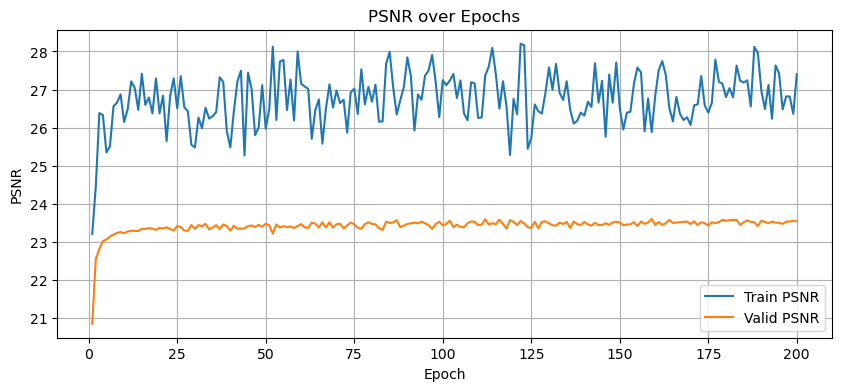

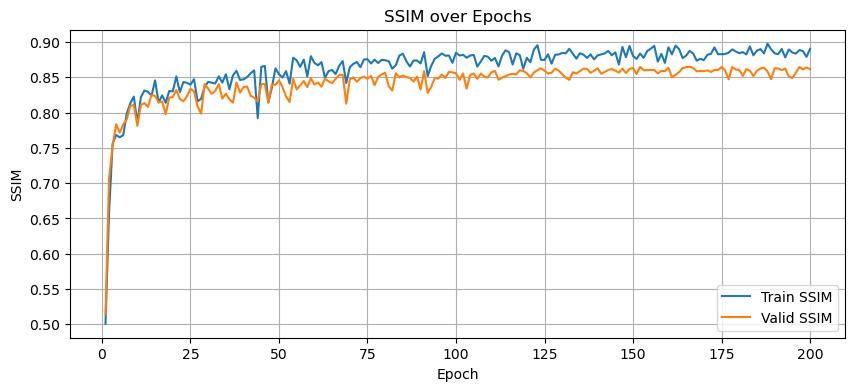

In [11]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_psnrs)+1))

# === PSNR ===
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_psnrs, label="Train PSNR")
plt.plot(epochs, val_psnrs, label="Valid PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title("PSNR over Epochs")
plt.legend()
plt.grid(True)
plt.show()
# === SSIM ===
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_ssims, label="Train SSIM")
plt.plot(epochs, val_ssims, label="Valid SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# 将数组保存为 .npy 文件
np.save("3_ssim_train.npy", train_ssims)
np.save("3_psnr_train.npy", train_psnrs)
np.save("3_ssim_valid.npy", val_ssims)
np.save("3_psnr_valid.npy", val_psnrs)

print("✅ 已保存为 3_ssim_train.npy, 1_psnr_train.npy, 1_ssim_valid.npy, 1_psnr_valid.npy")


✅ 已保存为 1_ssim_train.npy, 1_psnr_train.npy, 1_ssim_valid.npy, 1_psnr_valid.npy


In [ ]:
# 确保每个 tensor 都通过 .detach() 断开计算图，之后转移到 CPU 并转换为 NumPy 数组
train_maes_cpu = [mae.detach().cpu().numpy() for mae in train_maes]
train_rmses_cpu = [rmse.detach().cpu().numpy() for rmse in train_rmses]

# 保存为 .npy 文件
np.save("3_mae_train.npy", train_maes_cpu)
np.save("3_rmes_train.npy", train_rmses_cpu)


In [ ]:
# 确保每个 tensor 都通过 .detach() 断开计算图，之后转移到 CPU 并转换为 NumPy 数组
valid_maes_cpu = [mae.detach().cpu().numpy() for mae in val_maes]
valid_rmses_cpu = [rmse.detach().cpu().numpy() for rmse in val_rmses]

# 保存为 .npy 文件
np.save("3_mae_valid.npy", valid_maes_cpu)
np.save("3_rmes_valid.npy", valid_rmses_cpu)


In [ ]:
import numpy as np
import pandas as pd

# .npy 文件的列表
files = [
    "3_mae_train.npy", "3_mae_valid.npy", 
    "3_psnr_train.npy", "3_psnr_valid.npy",
    "3_rmes_train.npy", "3_rmes_valid.npy",
    "3_ssim_train.npy", "3_ssim_valid.npy"
]

# 创建一个字典来存储数据
data_dict = {}

# 加载每个 .npy 文件并存入字典
for file in files:
    data_dict[file] = np.load(file)

# 将字典转换为 pandas DataFrame
df = pd.DataFrame(data_dict)

# 将 DataFrame 保存为 CSV 文件
df.to_csv("metrics_data.csv", index=False)
